# Statistical Machine Learning Exercise Sheet 4
- Laura Haege
- Philipp Noel von Bachmann, Matrikelnummer: 4116220

## Exercise 7

### (a)

1.
Suppose there exist $y_1, y_2$ such that $P_C (x) = \{ y_1, y_2\}$ with $\Vert x-y_1\Vert_2^2=\Vert x-y_2\Vert_2^2 = a$. Now construct $y* = p \cdot y_1 + (1-p) \cdot y_2 \in P_C(x)$
\begin{align*}
    & \Vert x -  p \cdot y_1 + (1-p) \cdot y_2 \Vert_2^2 \\
    & = \Vert p \cdot x + (1-p) \cdot x - ( p \cdot y_1 + (1-p) \cdot y_2) \Vert_2^2 \\
    & = \Vert p \cdot x - p \cdot y_1 +(1-p) \cdot x  - (1-p) \cdot y_2 \Vert_2^2 \\
    & \leq \Vert p \cdot x - p \cdot y_1\Vert_2^2 + \Vert (1-p) \cdot x  - (1-p) \cdot y_2 \Vert_2^2 \\
    & = p^2 \cdot \Vert  x - y_1\Vert_2^2 + (1-p)^2 \cdot \Vert  x  - y_2 \Vert_2^2 \\
    & < p \cdot \Vert  x - y_1\Vert_2^2 + (1-p) \cdot \Vert  x  - y_2 \Vert_2^2 \\
    & = p \cdot a + (1-p) \cdot a \\
    &= a
\end{align*}
Therefore the distance to $y*$ is smaller than to $y_1, y_2$ and they can not be the minimum. Therefore the minimum has to be unique

2.
As we measure the distance in $L_2$, the distance within one component doesn't affect the distance within the other, and we can optimize each component seperatly. If $x_i<0$, then the closest point in $C$ is given by 0. Otherwise, we can just stay at $x_i$, which is the trivial minimal distance. This leads to $P_C(X)_i = max(x_i, 0)$. In total we get $P_C(X) = max(x, 0)$, where max is the element wise max.

# (b)

1.

In [1]:
from sys import prefix
import numpy as np
import matplotlib.pyplot as plt


def LassoObjective(wplus, wminus, Phi, Y, lmbd):
    ''' evaluates the objective function at (wplus, wminus)
    L2 loss + L1 regularization
    '''
    w = wplus - wminus
    return ((Phi @ w - Y) ** 2).mean(
        ) + lmbd * np.abs(w).sum()


def GradLassoObjective(wplus, wminus, Phi, Y, lmbd):
    ''' computes the gradients of the objective function
    at (wplus, wminus)
    gradwplus: gradient wrt wplus
    gradwminus: gradient wrt minus

    FILL IN
    '''
    prediction_loss = 2* (Y - Phi @ wplus + Phi @ wminus)
    gradwplus =  np.expand_dims(- np.sum(np.multiply(prediction_loss, Phi), axis=0) / Phi.shape[0] + lmbd, axis=1)
    gradwminus =   np.expand_dims(np.sum(np.multiply(prediction_loss, Phi), axis=0) / Phi.shape[0] + lmbd, axis=1)
    return gradwplus, gradwminus


def ProjectionPositiveOrthant(x):
    ''' returns the projection of x onto the positive orthant

    FILL IN
    '''
    return np.maximum(0, x)


def getStepSize(wplus, wminus, Phi, Y, lmbd, gradwplus,
                gradwminus, loss):
    ''' performs one step of projected gradient descent (i.e.
    compute next iterate) with step size selection via
    backtracking line search

    input
    loss: objective function at current iterate (wplus, wminus)

    output
    wplusnew, wminusnew: next iterates wplus_{t+1}, wminus_{t+1}
    lossnew: objective function at the new iterate
    
    FILL IN
    '''
    alpha, beta, sigma = 1., .1, .1
    wplusnew, wminusnew = wplus.copy(), wminus.copy()
    lossnew = np.float('Inf') # make sure to enter the loop

    # choose the step size alpha with backtracking line search
    while lossnew > loss + sigma * ((gradwplus * (
        wplusnew - wplus)).sum() + (gradwminus * (
        wminusnew - wminus)).sum()):
        # get new step size to test
        alpha *= beta

        # projected gradient step for wplus and wminus with step size alpha
        # i.e. compute x_{t+1} as in the text
        # FILL IN
        # print('fill in with projected gradient step')
        wplusnew = ProjectionPositiveOrthant(wplus - alpha * gradwplus)
        wminusnew = ProjectionPositiveOrthant(wminus - alpha * gradwminus)

        # compute new value of the objective
        lossnew = LassoObjective(wplusnew, wminusnew, Phi, Y, lmbd)

    return wplusnew, wminusnew, lossnew


def Lasso(Phi, Y, lmbd):
    ''' compute weight of linear regression with Lasso

    Phi: deisgn matrix n x d
    Y: true values n x 1
    lmbd: weight of regularization

    output: weights of linear regression d x 1
    '''
    # initialize wplus, wminus
    wplus = np.random.rand(Phi.shape[1], 1)
    wminus = np.random.rand(*wplus.shape)
    loss = LassoObjective(wplus, wminus, Phi, Y, lmbd)

    counter = 1
    while counter > 0:
        # compute gradients wrt wplus and wminus
        gradwplus, gradwminus = GradLassoObjective(
            wplus, wminus, Phi, Y, lmbd)

        # compute new iterates
        wplus, wminus, loss = getStepSize(wplus,
            wminus, Phi, Y, lmbd, gradwplus, gradwminus, loss)

        if (counter % 100) == 0:
            # check if stopping criterion is met
            wnew = wplus - wminus
            ind = wnew != 0.
            indz = wnew == 0.
            r = 2 / Phi.shape[0] * (Phi.T @ (Phi @ wnew - Y))
            stop = np.abs(r[ind] + lmbd * np.sign(wnew[ind]
                )).sum() + (np.abs(r[indz]) - lmbd * np.ones_like(
                r[indz])).clip(0.).sum()
            print('iter={} current objective={:.3f} nonzero weights={}'.format(
                counter, loss, ind.sum()) +\
                ' stop={:.5f}'.format(stop / Phi.shape[0]))
            if np.abs(stop) / Phi.shape[0] < 1e-5:
                break
        counter += 1

    return wplus - wminus



2.

In [2]:
# load data
data = np.load("multidim_data_trainval.npy", allow_pickle=True).item()
x_train = data["Xtrain"]
y_train = data["Ytrain"]
x_val = data["Xval"]
y_val = data["Yval"]

# normalize
x_train -= np.mean(x_train, axis=0)
x_train /= np.std(x_train, axis=0)
x_val -= np.mean(x_val, axis=0)
x_val /= np.std(x_val, axis=0)


# add one vector for offset
x_train = np.hstack((np.ones((x_train.shape[0], 1)), x_train))
x_val = np.hstack((np.ones((x_val.shape[0], 1)), x_val))

In [3]:
lmbd = 10

w = Lasso(x_train, y_train, lmbd=lmbd)
y_train_predict = x_train @ w
y_val_predict = x_val @ w
train_loss = np.linalg.norm(y_train - y_train_predict)**2/x_train.shape[0]
test_loss = np.linalg.norm(y_val - y_val_predict)**2/x_val.shape[0]


iter=100 current objective=139277.680 nonzero weights=63 stop=0.11879
iter=200 current objective=138925.125 nonzero weights=45 stop=0.03480
iter=300 current objective=138832.709 nonzero weights=44 stop=0.00569
iter=400 current objective=138786.650 nonzero weights=43 stop=0.00400
iter=500 current objective=138758.119 nonzero weights=43 stop=0.00305
iter=600 current objective=138738.583 nonzero weights=42 stop=0.00240
iter=700 current objective=138724.429 nonzero weights=42 stop=0.00194
iter=800 current objective=138716.244 nonzero weights=41 stop=0.00125
iter=900 current objective=138714.441 nonzero weights=41 stop=0.00078
iter=1000 current objective=138713.814 nonzero weights=40 stop=0.00048
iter=1100 current objective=138713.589 nonzero weights=40 stop=0.00030
iter=1200 current objective=138713.506 nonzero weights=40 stop=0.00018
iter=1300 current objective=138713.476 nonzero weights=40 stop=0.00011
iter=1400 current objective=138713.464 nonzero weights=40 stop=0.00007
iter=1500 curre

i.

In [4]:
print(f"The training loss is {train_loss} and the test loss is {test_loss}")

The training loss is 121332.09617441503 and the test loss is 141717.19168760636


ii.

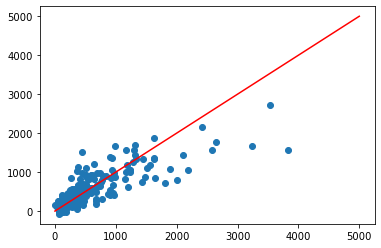

In [5]:

perfect_fit = np.linspace(0, 5000)
plt.scatter(y_val, y_val_predict)
plt.plot(perfect_fit, perfect_fit, color="red")

We can see that for small values, the predictions are very good. However for larger values, the predictions get more inaccurate

In [6]:
def basis(X):
    return np.hstack([X, np.sin(np.pi * X), np.cos(np.pi * X)])

In [7]:
def train(X, Y):
    X = basis(X)
    w = Lasso(X, Y, lmbd=5)
    return w

In [8]:
w_predict = train(x_train, y_train)

iter=100 current objective=121815.273 nonzero weights=229 stop=0.28289
iter=200 current objective=120535.502 nonzero weights=191 stop=0.20205
iter=300 current objective=120065.688 nonzero weights=195 stop=0.12329
iter=400 current objective=119775.663 nonzero weights=184 stop=0.13487
iter=500 current objective=119604.110 nonzero weights=185 stop=0.06124
iter=600 current objective=119506.657 nonzero weights=180 stop=0.04667
iter=700 current objective=119453.600 nonzero weights=180 stop=0.02954
iter=800 current objective=119413.800 nonzero weights=177 stop=0.04661
iter=900 current objective=119381.764 nonzero weights=179 stop=0.03385
iter=1000 current objective=119354.426 nonzero weights=179 stop=0.03198
iter=1100 current objective=119330.297 nonzero weights=179 stop=0.02725
iter=1200 current objective=119308.427 nonzero weights=179 stop=0.02730
iter=1300 current objective=119288.177 nonzero weights=176 stop=0.03379
iter=1400 current objective=119269.033 nonzero weights=177 stop=0.01911
i

In [9]:
def Prediction(X):
    return basis(X) @ w_predict

## Exercise 8

### (a)
The minimization problem is convex because the primal problem is convex ($L_2$ norm is convex), and the equality constrain $Xw=b$ is linear.

### (b)
First step: Show that the solution satisfies the constrain:
\begin{align*}
X (w_0 - X^T (XX^T)^{-1} (Xw_0 - b))
&= X w_0 - X (X^T (XX^T)^{-1} (Xw_0 - b)) \\
&= X w_0 - XX^T (XX^T)^{-1} (Xw_0 - b)) \\
&= X w_0 - (Xw_0 - b)) \\
&= X w_0 - Xw_0 + b \\
&= b \\
\end{align*}

Now setup Lagrange Dual Problem:
\begin{align*}
L(w, v) &= \Vert w-w_0 \Vert + v^T (Xw - b) \\
\end{align*}
Compute derivative
\begin{align*}
\nabla_w L(w, v) &= \nabla_w \Vert w-w_0 \Vert + v^T (Xw - b) \\
&= 2(w-w_0) + v^T X \\
\end{align*}

Set to 0:
\begin{align*}
 0 & = 2(w-w_0) + v^T X \\
 w & = - v^T X \frac{1}{2} + w_0\\
\end{align*}

Plug in $L$ to get $g$.
\begin{align*}
g(v) = L(- v^T X \frac{1}{2} + w_0, v)
&= \Vert - v^T X \frac{1}{2} + w_0 -w_0 \Vert + v^T (X(- v^T X \frac{1}{2} + w_0) - b)\\
&= \frac{1}{4} \Vert v^T X \Vert + v^T (X(- v^T X \frac{1}{2} + w_0) - b)
\end{align*}
